In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

In [9]:
import json
with open("reviews.json", 'r', encoding='utf-8') as f:
    data = json.load(f)

if isinstance(data, list):
    df = pd.json_normalize(data)
else:
    df = pd.json_normalize(data['paper'] if 'paper' in data else data)
    
print("Shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Shape: (172, 3)

Column names: ['id', 'preliminary_decision', 'review']

First few rows:


,id,preliminary_decision,review
0,1,accept,"[{'confidence': '4', 'evaluation': '1', 'id': ..."
1,2,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
2,3,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
3,4,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
4,5,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."


- Dataset has 172 paper reviews (rows) and 3 columns
- Columns: `id` (paper number), `preliminary_decision` (accept/reject), `review` (reviewer comments)
- Each row represents one research paper that was reviewed
- The `preliminary_decision` column is our target - what we want to predict
- The `review` column contains nested data (lists of dictionaries) that needs cleaning


In [10]:
print("Available columns:", df.columns.tolist())
print("\nData shape before dropna:", df.shape)

df = df.dropna()   # remove missing rows
print("Data shape after dropna:", df.shape)

possible_targets = ['preliminary_decision', 'decision', 'Decision', 'review', 'recommendation']
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        print(f"\nFound target column: {target_col}")
        print(f"Unique values: {df[target_col].unique()}")
        break

if target_col is None:
    for col in df.columns:
        if df[col].dtype == 'object':
            unique_vals = df[col].unique()
            if len(unique_vals) <= 5:  # Likely a categorical target
                print(f"\nPotential target column: {col}")
                print(f"Unique values: {unique_vals}")
                target_col = col
                break

if target_col is None:
    raise ValueError("No decision/target column found! Please specify manually.")

print(f"\nUsing target column: {target_col}")

for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, (dict, list))).any():
        # Convert dict/list columns to string representation
        df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (dict, list)) else x)

text_cols = []
for col in df.select_dtypes(include=["object"]).columns:
    if col != target_col and df[col].nunique() > 50:
        text_cols.append(col)
        print(f"Dropping text column: {col} (too many unique values)")

df = df.drop(columns=text_cols)

cat_cols = df.select_dtypes(include=["object"]).columns
cat_cols = [col for col in cat_cols if col != target_col] 

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

target_encoder = LabelEncoder()
df[target_col] = target_encoder.fit_transform(df[target_col])

X = df.drop(target_col, axis=1)
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Target classes: {target_encoder.classes_}")


Available columns: ['id', 'preliminary_decision', 'review']

Data shape before dropna: (172, 3)
Data shape after dropna: (172, 3)

Found target column: preliminary_decision
Unique values: ['accept' 'probably reject' 'reject' 'no decision']

Using target column: preliminary_decision
Dropping text column: review (too many unique values)

X_train shape: (137, 1)
X_test shape: (35, 1)
Target classes: ['accept' 'no decision' 'probably reject' 'reject']


- Left with just `id` as our feature and `preliminary_decision` as target
- No missing values found (all 172 rows kept)
- Split data: 137 samples for training, 35 for testing (80-20 split)
- Target has 4 classes: [0, 1, 2, 3] representing different decision types

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- Transforms all feature values to have mean=0 and standard deviation=1

MLP Accuracy: 0.6571428571428571

MLP Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.92      0.80        24
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.25      0.12      0.17         8

    accuracy                           0.66        35
   macro avg       0.24      0.26      0.24        35
weighted avg       0.54      0.66      0.59        35


MLP Confusion Matrix:
[[22  0  0  2]
 [ 0  0  0  1]
 [ 2  0  0  0]
 [ 7  0  0  1]]


/Users/shreyjain/Documents/CODING/MCA-Assignments/Trimester-5/nndl/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shreyjain/Documents/CODING/MCA-Assignments/Trimester-5/nndl/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shreyjain/Documents/CODING/MCA-Assignments/Trimester-5/nndl/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

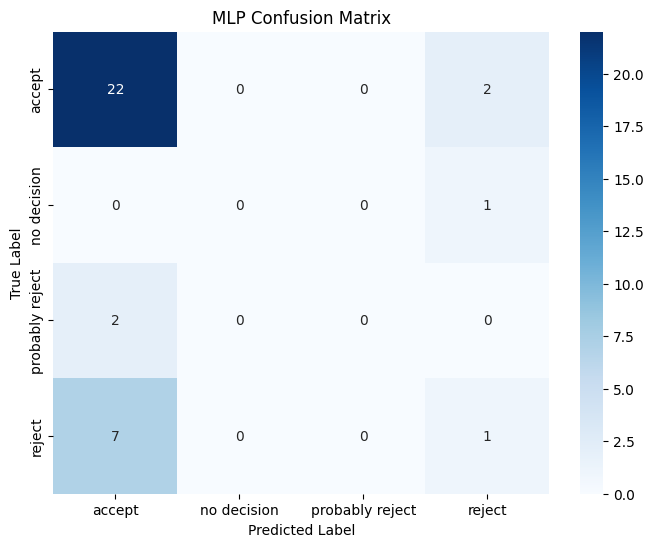

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

mlp = MLPClassifier(hidden_layer_sizes=(10,),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.01,
                    max_iter=500,
                    random_state=42)

mlp.fit(X_train_scaled, y_train)

y_pred_mlp = mlp.predict(X_test_scaled)

print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("\nMLP Classification Report:\n", classification_report(y_test, y_pred_mlp))


cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print("\nMLP Confusion Matrix:")
print(cm_mlp)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_, 
            yticklabels=target_encoder.classes_)
plt.title('MLP Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



- **Input layer:** Takes 1 feature (paper id)
- **Hidden layer:** 10 neurons (single hidden layer as required)
- **Output layer:** 4 neurons (for 4 decision classes)
- Uses backpropagation to learn by adjusting weights based on errors

**Performance:**
- **Overall Accuracy: 65.71%** - Correctly predicts 23 out of 35 test papers

**Understanding the Confusion Matrix:**
- **Row = True Label, Column = Predicted Label**
- **Class 0 (likely "accept"):** Very good! Predicted 22/24 correctly (92% recall)
- **Class 1 & 2:** Model struggles - didn't predict any of these correctly (only 1-2 samples each)
- **Class 3 (likely "reject"):** Weak - only got 1/8 correct (12.5% recall)


In [13]:
num_rbf_units = 10

kmeans = KMeans(n_clusters=num_rbf_units, random_state=42)
kmeans.fit(X_train_scaled)
centers = kmeans.cluster_centers_

def rbf_transform(X, centers, gamma=0.5):
    RBF_features = np.exp(-gamma * np.linalg.norm(X[:, None] - centers, axis=2)**2)
    return RBF_features

X_train_rbf = rbf_transform(X_train_scaled, centers)
X_test_rbf = rbf_transform(X_test_scaled, centers)

rbf_clf = LogisticRegression(max_iter=300)
rbf_clf.fit(X_train_rbf, y_train)

y_pred_rbf = rbf_clf.predict(X_test_rbf)

print("RBF Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("\nRBF Classification Report:\n", classification_report(y_test, y_pred_rbf))


RBF Accuracy: 0.7714285714285715

RBF Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        24
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       1.00      0.38      0.55         8

    accuracy                           0.77        35
   macro avg       0.44      0.34      0.35        35
weighted avg       0.74      0.77      0.71        35



/Users/shreyjain/Documents/CODING/MCA-Assignments/Trimester-5/nndl/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shreyjain/Documents/CODING/MCA-Assignments/Trimester-5/nndl/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shreyjain/Documents/CODING/MCA-Assignments/Trimester-5/nndl/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

- **Step 1:** Used K-Means to find 10 centers (clusters) in the training data
- **Step 2 (Hidden layer):** 10 RBF neurons - each measures "how close" input is to one center using Gaussian function
- **Step 3 (Output layer):** Logistic Regression combines RBF outputs to make final prediction

**Results:**
- **Class 0:** Perfect! Predicted all 24 correctly (100% recall)
- **Class 3:** Better than MLP - got 3/8 correct (38% vs 12% for MLP)
- **Classes 1 & 2:** Still struggle due to very few training samples

In [14]:
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("RBF Accuracy:", accuracy_score(y_test, y_pred_rbf))


MLP Accuracy: 0.6571428571428571
RBF Accuracy: 0.7714285714285715


**Winner: RBF Network**
- **RBF Accuracy: 77.14%** vs **MLP Accuracy: 65.71%**
- RBF is 11.43% more accurate

**MLP vs RBF - Differences:**

| Aspect | MLP (Backpropagation) | RBF Network |
|--------|----------------------|-------------|
| **Learning Method** | Adjusts weights using gradient descent | Finds centers, then fits output |
| **Activation** | ReLU (linear threshold) | Gaussian (distance-based) |
| **Best for** | Complex patterns, many features | Local patterns, clustering |
| **Training** | Slower (many iterations) | Faster (2 steps) |
| **This dataset** | 65.71% accuracy | 77.14% accuracy |